
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# set values if testing
import os

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

from xopt.generators.bayesian.objectives import feasibility

import matplotlib.pyplot as plt

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20
N_STEPS = 1 if SMOKE_TEST else 30

evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'observables': []}


In [2]:
generator = MOBOGenerator(vocs=tnk_vocs, reference_point={"y1": 1.5, "y2": 1.5})
generator.n_monte_carlo_samples = N_MC_SAMPLES
generator.numerical_optimizer.n_restarts = NUM_RESTARTS

X = Xopt(generator=generator, evaluator=evaluator, vocs=tnk_vocs)
X.evaluate_data(pd.DataFrame({"x1": [1.0, 0.75], "x2": [0.75, 1.0]}))

for i in range(N_STEPS):
    print(i)
    X.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


KeyboardInterrupt: 

In [3]:
X.generator.data

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,1.000000,0.750000,dummy_constant,1.000000,0.750000,0.626888,0.312500,0.000030,False
1,0.750000,1.000000,dummy_constant,0.750000,1.000000,0.626888,0.312500,0.000008,False
2,1.484075,0.336814,dummy_constant,1.484075,0.336814,1.406853,0.995033,0.000020,False
3,0.683296,0.141031,dummy_constant,0.683296,0.141031,-0.413878,0.162456,0.000026,False
4,0.063611,0.000000,dummy_constant,0.063611,0.000000,-1.095954,0.440435,0.000027,False
5,0.000000,3.141590,dummy_constant,0.000000,3.141590,8.769588,7.227998,0.000017,False
6,0.950229,0.126257,dummy_constant,0.950229,0.126257,-0.029476,0.342390,0.000022,False
7,0.097596,0.956306,dummy_constant,0.097596,0.956306,-0.070311,0.370144,0.000022,False
8,0.109974,1.017885,dummy_constant,0.109974,1.017885,0.063247,0.420325,0.000022,False
9,1.005731,0.052919,dummy_constant,1.005731,0.052919,-0.052369,0.455645,0.000018,False


## plot results


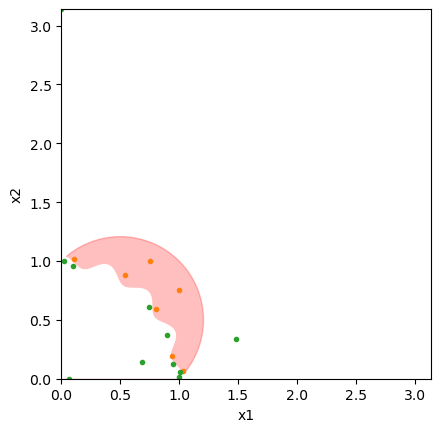

In [4]:
fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5**0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)


ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

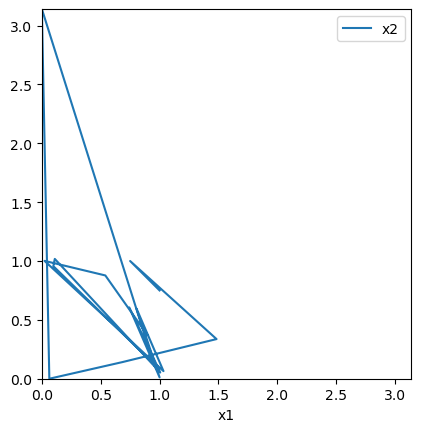

In [5]:
ax = history.plot("x1", "x2")
ax.set_ylim(0, 3.14)
ax.set_xlim(0, 3.14)
ax.set_aspect("equal")

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


(<Figure size 800x1650 with 19 Axes>,
 array([[<Axes: title={'center': 'Posterior Mean [y1]'}, ylabel='x2'>,
         <Axes: title={'center': 'Posterior SD [y1]'}>],
        [<Axes: title={'center': 'Posterior Mean [y2]'}, ylabel='x2'>,
         <Axes: title={'center': 'Posterior SD [y2]'}>],
        [<Axes: title={'center': 'Posterior Mean [c1]'}, ylabel='x2'>,
         <Axes: title={'center': 'Posterior SD [c1]'}>],
        [<Axes: title={'center': 'Posterior Mean [c2]'}, ylabel='x2'>,
         <Axes: title={'center': 'Posterior SD [c2]'}>],
        [<Axes: title={'center': 'Acq. Function'}, xlabel='x1', ylabel='x2'>,
         <Axes: xlabel='x1'>]], dtype=object))

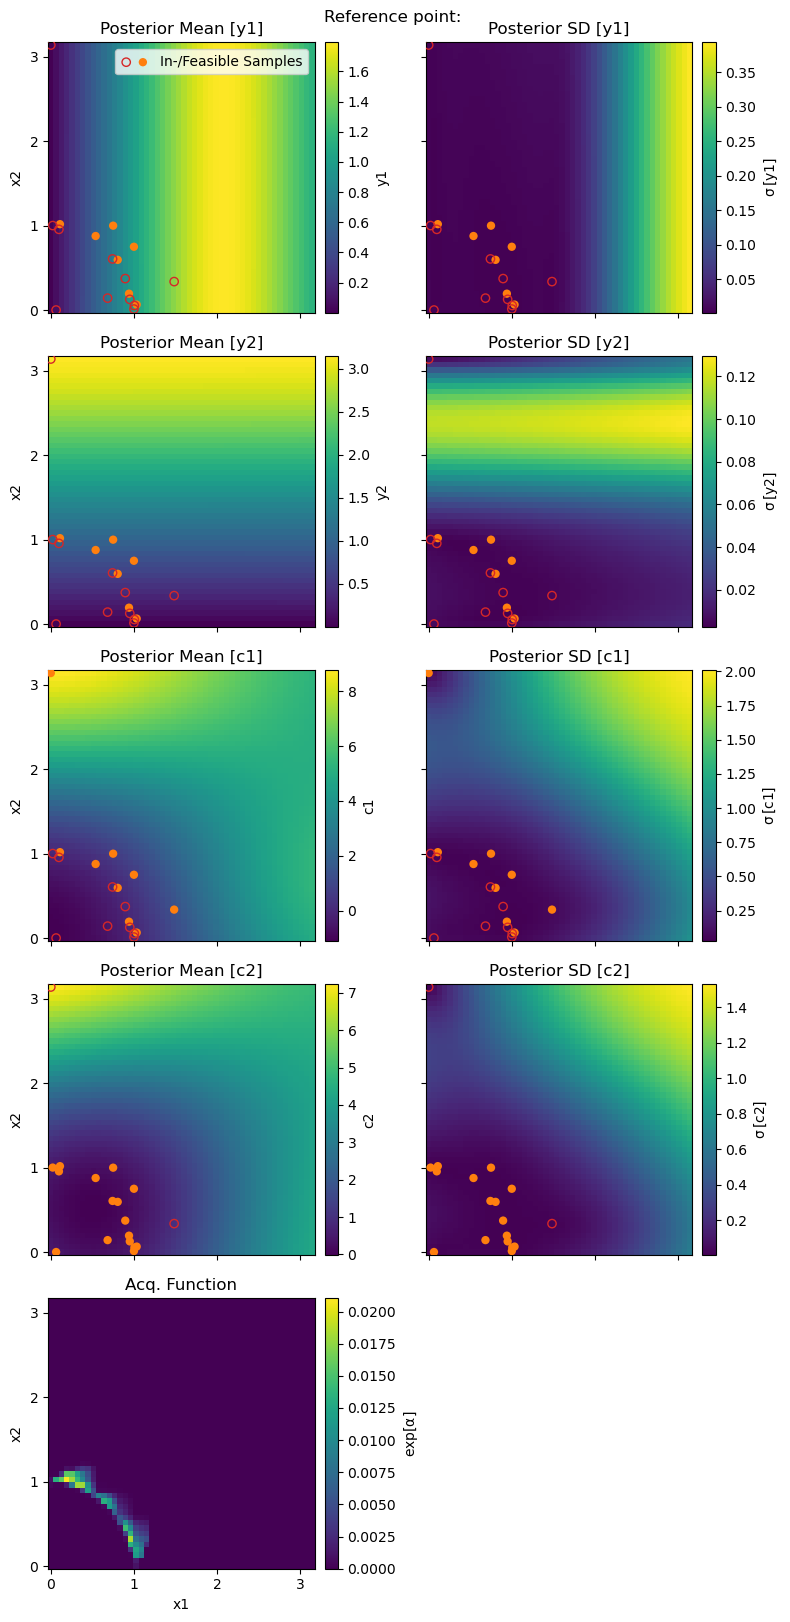

In [6]:
## visualize model
X.generator.visualize_model()